$\require{mhchem}$
# Analyse AIRSS Search results
For $\ce{Ag2Se}$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Plot VASP refine results

In [3]:
%aiida
import pandas as pd
from aiida.orm import Group, QueryBuilder, StructureData,Code, Computer
# Gruop containing the res structures for easy access
res_structgroup = Group.objects.get(label='ag2se/run4/airss-refine-structure')

In [4]:
def get_xc_type(param, sfamily):
    
    xc = 'unknown'
    if sfamily.startswith('LDA'):
        xc = 'lda'
    if isinstance(param, Dict):
        param = param.get_dict()['vasp']
    else:
        param = param['vasp']
    
    gga = param.get('gga', 'PE')
    if gga and xc == 'lda':
        xc = 'gga+ldapp'
        
    if gga.upper() == 'PE':
        if param.get('lhfcalc'):
            xc = 'hse06'
        xc = 'pbe'
    if gga == 'ps':
        xc = 'pbesol'
    if 'ldau' in 'param':
        xc += '+u'
    return xc

import re
# Patter matching the name
pat = re.compile(r'([\w\-_]+)\.res')

def get_dataframe(group, lkey=0):
    """Obtained relaxed structures for a particular group"""

    q = QueryBuilder()
    q.append(Group, filters={'id': group.pk})
    q.append(StructureData, with_group=Group, project=['id'])
    q.append(WorkChainNode, with_incoming=StructureData, filters={'attributes.exit_status': {'in': [0, 406, 600]},
                                                                  'process_type': {'like': '%relax'}
                                                                 },
             project=['uuid', 'label'])
    q.append(Str, with_outgoing=WorkChainNode, edge_filters={'label': 'vasp__potential_family'}, project='attributes.value')
    q.append(Dict, with_incoming=WorkChainNode, project=['attributes.total_energies.energy_no_entropy'])
    q.append(StructureData, edge_filters={'label': 'relax__structure'}, with_incoming=WorkChainNode, project=['*', 'id'], edge_project=['label'])
    q.append(Dict, with_outgoing=WorkChainNode, edge_filters={'label': 'vasp__parameters'}, project=['attributes'], 
             filters={'attributes.vasp.encut': 550}
            )
    q.distinct()
    res = q.all()
    
    q = QueryBuilder()
    q.append(Group, filters={'id': group.pk})
    q.append(StructureData, with_group=Group, project=['id'])
    q.append(WorkChainNode, with_incoming=StructureData, filters={'attributes.exit_status': {'in': [0, 406, 600]},
                                                                  'process_type': {'like': '%relax'}
                                                                 },
             project=['uuid', 'label'])
    q.append(Str, with_outgoing=WorkChainNode, edge_filters={'label': 'potential_family'}, project='attributes.value')
    q.append(Dict, with_incoming=WorkChainNode, project=['attributes.total_energies.energy_no_entropy'])
    q.append(StructureData, edge_filters={'label': 'relax__structure'}, with_incoming=WorkChainNode, project=['*', 'id'], edge_project=['label'])
    q.append(Dict, with_outgoing=WorkChainNode, edge_filters={'label': 'parameters'}, project=['attributes'], 
             filters={'attributes.vasp.encut': 550}
            )
    q.distinct()
    res.extend(q.all())
    
    
    results = []
    for spk, rpk, rlabel, family_string,  eng, struct, rspk, calc_param, elabel in res:
        funits = struct.get_pymatgen().composition.get_integer_formula_and_factor()[1]
        name = 'Ag2Se GUNTER' if 'GUNTER' in rlabel else rlabel.split()[lkey] 
        results.append({'label': str(name), 'relax_work': rpk, 'relaxed': rspk, 'energy': eng,
                        'energy_fu': eng / funits, 'nform': funits, 
                        'volume': struct.get_cell_volume(), 
                        'volume_fu': struct.get_cell_volume() / funits,
                        'xc': get_xc_type(calc_param, family_string),
                        'elabel': elabel,
                        **calc_param['vasp']
                       })
    return pd.DataFrame.from_records(results)

In [5]:
def type_string(label):
    if 'mp' in label:
        return 'MP'
    elif '20200927' in label:
        return 'EXP'
    return 'AIRSS'

In [6]:
Group.objects.get(label='ag2se/run2/airss-refine-structure')

<Group: "ag2se/run2/airss-refine-structure" [type core], of user bonan.zhu@ucl.ac.uk>

In [7]:
dfs = []
for resgroup in [res_structgroup, Group.objects.get(label='ag2se/run2/airss-refine-structure'), 
                                                    Group.objects.get(label='ag2se/run1/airss-refine-structure')]:
    res_vasp_df = get_dataframe(resgroup)
    vasp_df = res_vasp_df
    vasp_df['type'] = vasp_df.label.apply(type_string)
    vasp_df['group'] = resgroup.label
    vasp_df['label'] = vasp_df['label'].str.replace('-P2', '_P2')
    dfs.append(vasp_df)
vasp_df = pd.concat(dfs)

vasp_df['label'] = vasp_df['label'].str.replace('-P2', '_P2')
vasp_df['seed_name'] = vasp_df['label'].apply(lambda x: x.split('-')[0])
vasp_df['energy_pa'] = vasp_df['energy_fu'] / 3 # 3 atoms per unit cell

#Drop the LDA results
vasp_df = vasp_df[vasp_df.xc != 'lda']

In [8]:
group = Group.objects.get_or_create(label='ag2se/refine-relaxations')[0]

group.add_nodes([load_node(node) for node in vasp_df.relax_work.values])

# Reference for each ex

In [9]:
vasp_df['energy_pa_ref'] = vasp_df['energy_pa']
for xc in vasp_df.xc.unique():
    ref_eng = vasp_df.loc[vasp_df.xc == xc, 'energy_pa'].min()
    vasp_df.loc[vasp_df.xc == xc, 'energy_pa_ref'] = vasp_df.loc[vasp_df.xc == xc, 'energy_pa_ref'] - ref_eng

## Plotting

In [10]:
vasp_df.to_csv('vasp_refine_data.csv')

In [11]:
plt.style.use('publication_mp_style')

In [12]:
df_all = pd.read_csv('vasp_refine_data.csv')
df_pbesol = df_all[df_all.xc == 'pbesol'].copy().reset_index()
min_ids = df_pbesol.groupby('label')['energy'].idxmin()
# Remove duplicated calculaation - take the minimum energy for each label
df_pbesol_min = df_pbesol.loc[min_ids]

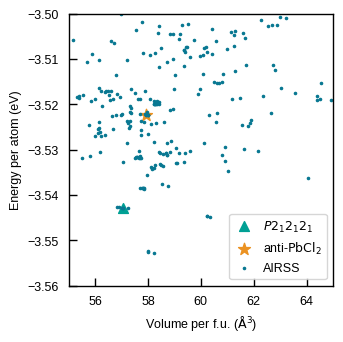

In [13]:
fig = plt.figure(dpi=100)

type_name = 'MP'
selected = df_pbesol_min[df_pbesol_min.type == type_name]
plt.scatter(selected.volume_fu, selected.energy_pa, s=50, marker='^', label=r'$P2_12_12_1$')
type_name = 'EXP'
selected = df_pbesol_min[df_pbesol_min.type == type_name]
plt.scatter(selected.volume_fu, selected.energy_pa, s=80, 
            #c='xkcd:red', 
            marker='*', label=r'anti-$\mathrm{PbCl_2}$')
type_name = 'AIRSS'
selected = df_pbesol_min[df_pbesol_min.type == type_name]
plt.scatter(selected.volume_fu, selected.energy_pa, s=10, marker='.', 
           # c='xkcd: orchid'
            label='AIRSS'
           )

plt.ylim(-3.56, -3.50)
plt.xlim(55, 65)
plt.xlabel(r'Volume per f.u. ($\mathrm{\AA^3}$)')
plt.ylabel(r'Energy per atom (eV)')
plt.legend()
plt.tight_layout()
plt.savefig('search_result.svg')

# Save the structures

In [14]:
!mkdir refined-structures

In [16]:
from ase.io import write
df_all.to_csv('../refined-structures/vasp_refine_data.csv')

atoms_list = []
labels = []
for i, (_, row) in enumerate(vasp_df[vasp_df['xc'] =='pbesol'].sort_values('energy_fu').iterrows()):
    atoms = load_node(row['relaxed']).get_ase()
    atoms.info.update(row.to_dict())
    atoms_list.append(atoms)
    labels.append(atoms.info['label'][-6:])
    atoms.write(f"../refined-structures/{i:03d}-{row.label}.vasp")

with open("label.dat", "w") as fh:
    fh.write('\n'.join(labels))